## Child Mind Sleep States

EC523 Final Project
Team members: Sam Zhou, Erynne San Antonio, Masha Lazou, Laura Carlton

Credit to this kaggle post for providing some of the preprocessing code: https://www.kaggle.com/code/danielphalen/cmss-grunet-train

Any code that is borrowed from the above notebook without significant alteration will be clearly denoted with a '### From Kaggle Start ###' and '### From Kaggle End ###

This notebook is divided into preprocessing, layer definition, model training, and model scoring.

Final model is prefaced with 'FINAL MODEL' in heading.

TO RUN THIS CODE:
1) Ensure all necessary data files are in the same directory. This includes:
    - All .parquet files by SERIES_ID
    - train_events.csv
    - train_series.parquet
    - test_series.parquet
2) Change path names in the PATHS class in the preprocessing section. MAIN_DIR and SPLIT_DIR are the same if all above files are in the same directory
3) Run the notebook up until just after parameter definition. That is, the first cell after the "Training" header.
4) Go through the notebook and pick a model to train. The final model is labeled as 'FINAL MODEL' in the section header.
5) Run the evaluation code in the 'Evaluation' section.

In [68]:
# import all required packages 

import torch
from torch import nn, Tensor
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.metrics import average_precision_score    
import pandas as pd
import numpy as np
import gc
from math import pi, sqrt, exp
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import ctypes
import torch
from torch.utils.data import Dataset, DataLoader
import copy
import random
from torch.utils.data import TensorDataset



## Preprocessing

In [69]:

### From Kaggle Start ###

class PATHS:
    #Base directories for the main and split data
    
    # *** CHANGE THESE TO RUN NOTEBOOK ***
    
    MAIN_DIR = '/projectnb/ec523kb/projects/cmi/FinalProject/Data/'
    SPLIT_DIR = '/projectnb/ec523kb/projects/cmi/FinalProject/Data/'
    
    # *************************************
    
    #Paths to CSV files
    SUBMISSION = MAIN_DIR + "sample_submission.csv"  # Path to the submission format CSV
    TRAIN_EVENTS = MAIN_DIR + "train_events.csv"  # Path to the training events CSV
    
    #Paths to Parquet files
    TRAIN_SERIES = MAIN_DIR + "train_series.parquet"  # Path to the training series Parquet file
    TEST_SERIES = MAIN_DIR + "test_series.parquet"  # Path to the test series Parquet file
    
    @staticmethod
    def get_series_filename(series_id):
        #Generates a filename for a test series Parquet file based on a given series ID
        f = f'{series_id}_test_series.parquet'
        return PATHS.SPLIT_DIR + f  #Returns the full path to the file
    
class CFG:
    #Configuration flags and parameters
    DEMO_MODE = False  #Flag to indicate whether the script is running in demo mode
    VERBOSE = True  #Flag to control the verbosity of the script's output
    
    SEED = 42  #Seed value for reproducibility of results
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  #Device configuration for PyTorch (GPU or CPU)

def clean_memory():
    gc.collect()  #Trigger Python's garbage collection to free unused memory.
    ctypes.CDLL("libc.so.6").malloc_trim(0)  #Call malloc_trim from the C library to release free blocks of memory back to the operating system, potentially reducing the memory footprint of the program.
    torch.cuda.empty_cache()  #Clear PyTorch's CUDA memory cache to release GPU memory that might have been cached by PyTorch during computations.

def get_longest_continuous(gdf):
    """Function will find longest subsequence of a training set where there is an event each night"""
    c = sorted(list(set(gdf[gdf['event'] == 'onset'].dropna().night.unique()) & set(gdf[gdf['event'] == 'wakeup'].dropna().night.unique())))
    start = -1
    end = -1
    m = 0
    save = 0,0
    last = start
    for x in c:
        if x == last + 1:
            end = x
            last = x
        else:
            v = end - start
            if v > m:
                save = start, end
                m = v
            start = x
            end = x
            last = x

    v = end - start
    if v > m:
        save = start, end
        m = v
        
    return save

train_events = pd.read_csv(PATHS.TRAIN_EVENTS)
print(len(train_events))

drop_series = []  #store series IDs that will be dropped
continuous = {}  #Dictionary to store the start and end of the longest continuous segment for each series

# Iterate over each group of events in 'train_events', grouped by 'series_id'
for series_id, gdf in train_events.groupby('series_id'):
    tmp = gdf.dropna() 

    if len(tmp) == 0:
        drop_series.append(series_id)  # Add series ID to the drop list if group is empty
    else:
        start, end = get_longest_continuous(gdf)

        if end - start == 0: # Check if the continuous segment is of zero length
            drop_series.append(series_id) 
        else:
            continuous[series_id] = start, end

print(f'Dropped {len(drop_series)} series')

series_ids = train_events['series_id'].unique()

# get list of usable series ids and shuffle
useable_series_ids = [s for s in series_ids if s not in drop_series]
if CFG.DEMO_MODE:
    useable_series_ids = useable_series_ids[:]
    
np.random.shuffle(useable_series_ids)
len(useable_series_ids)

### From Kaggle End ###

14508
Dropped 18 series


259

In [70]:
max_chunk_size = 24*60*12 # number of samples in one day
min_interval = 30

In [71]:
# convert series_ids to list and randomly sample 80% of them to get training set
series_ids_list = list(np.arange(len(useable_series_ids)))
train_ids = random.sample(series_ids_list, k=round(len(series_ids_list) * 0.8))

# get list of train series_ids 
train_series_ids = list(series_ids[train_ids])

# test series_ids are all ids not used in training
test_series_ids = [series_ids[i] for i in range(len(series_ids_list)) if series_ids[i] not in train_series_ids]

In [72]:
print(len(train_series_ids))
print(len(test_series_ids))

207
52


In [73]:
### From Kaggle Start ###

class SleepDatasetTrain(Dataset):
    """
    Dataset for Child Mind Sleep States.  We have it output just the raw anglez and enmo variables.
    
    :param series_ids: list of series ids in this set
    :param events: The events dataframe
    :param len_mult: The total length of the sequence must be a multiple of this integer
    :param continuous: dictionary of series_id to start and end points, if we want to trim to continuous series
    :param sigma: The width of the distribution to use for output.
        """
    def __init__(
        self,
        series_ids,
        events,
        len_mult,
        continuous = None,
        sigma = None
    ):
        self.series_ids = series_ids
        self.continuous = continuous
        self.len_mult = len_mult
        if events is not None:
            self.events = events
            self.sigma = sigma
        else:
            self.events = None
            self.sigma = None
    
    def load_data(self, series_id):
        filename = PATHS.get_series_filename(series_id)
        data = pd.read_parquet(filename)
        if self.events is not None:
            if self.continuous is not None:
                if series_id:
                    start, end = self.continuous[series_id]
            else:
                start, end = 0, 1000000
            gap = 6*60*12
            tmp = self.events[(self.events.series_id == series_id) & (self.events.night >= start) & (self.events.night <= end)]
            data = data[(data.step > (tmp.step.min() - gap)) & (data.step < (tmp.step.max() + gap))]
            
            data = data.set_index(['series_id', 'step']).join(tmp.set_index(['series_id', 'step'])[['event', 'night']]).reset_index()
            norm = 1/ np.sqrt(pi / self.sigma)
            for evt in ['wakeup', 'onset']:
                steps = data[data.event == evt]['step'].values
                col = f'{evt}_val'
                data[col] = 0.0
                for i in steps:
                    x = 0.5*((data.step.astype(np.int64) - i)/self.sigma)**2
                    data[col] += np.exp(-x)*norm
                data[col] /= data[col].sum()
                
        n = int((len(data) // len_mult) * len_mult)
        
        return data.iloc[:n]
        
    def __len__(self):
        return len(self.series_ids)

    def __getitem__(self, index):
        series_id = self.series_ids[index]
        data = self.load_data(series_id)
        X = data[['anglez','enmo']].values.astype(np.float32)
        X = torch.from_numpy(X)
        if self.sigma is not None:
            Y = data[['wakeup_val', 'onset_val']].values.astype(np.float32)
            Y = torch.from_numpy(Y)
            return X, Y
        else:
            return X
        
### From Kaggle End ###

## Create training set and test sets by dividing each series into equal sized samples of exactly one day long

In [74]:
# This cell initializes and processes the training dataset for our LSTM model.

# We then iterate over each data point in the train_ds dataset. For each data point, we:
# 1. Extract the x and y components (representing features and labels respectively).
# 2. Calculate the number of complete batches that fit in a day based on 'day_len'.
# 3. Truncate the x and y sequences to include only complete batches.
# 4. Reshape the truncated sequences into a 3D tensor with dimensions: number of batches, day_len, and number of features.


len_mult=8
train_ds = SleepDatasetTrain(train_series_ids, events=train_events, len_mult=8, continuous=continuous, sigma=60)
day_len = 24*60*12 #Define the lenghth of one day
x_batches = []
y_batches = []

for i in range(len(train_ds)):
    try:
        x, y = train_ds[i]
    except KeyError:
        continue
    
    whole_seq_len, num_features = x.shape
    num_batches = whole_seq_len // day_len
    x_truncated = x[:num_batches * day_len]
    x_reshaped = x_truncated.view(num_batches, day_len, num_features)
    x_batches.append(x_reshaped)
    
    whole_seq_len, num_features = y.shape
    num_batches = whole_seq_len // day_len
    y_truncated = y[:num_batches * day_len]
    y_reshaped = y_truncated.view(num_batches, day_len, num_features)
    y_batches.append(y_reshaped)



In [75]:
x_train = torch.cat(x_batches, dim=0)
y_train = torch.cat(y_batches, dim=0)

# validate they are the same size 
print(x_train.shape)
print(y_train.shape)

torch.Size([2392, 17280, 2])
torch.Size([2392, 17280, 2])


In [76]:
# This cell initializes and processes the testing dataset for our LSTM model.

# We then iterate over each data point in the train_ds dataset. For each data point, we:
# 1. Extract the x and y components (representing features and labels respectively).
# 2. Calculate the number of complete batches that fit in a day based on 'day_len'.
# 3. Truncate the x and y sequences to include only complete batches.
# 4. Reshape the truncated sequences into a 3D tensor with dimensions: number of batches, day_len, and number of features.


len_mult=8
test_ds = SleepDatasetTrain(test_series_ids, events=train_events, len_mult=8, continuous=continuous, sigma=60)
day_len = 24*60*12
x_batches = []
y_batches = []

for i in range(len(test_ds)):
    try:
        x, y = test_ds[i]
    except KeyError:
        continue
    
    whole_seq_len, num_features = x.shape
    num_batches = whole_seq_len // day_len
    x_truncated = x[:num_batches * day_len]
    x_reshaped = x_truncated.view(num_batches, day_len, num_features)
    x_batches.append(x_reshaped)
    
    whole_seq_len, num_features = y.shape
    num_batches = whole_seq_len // day_len
    y_truncated = y[:num_batches * day_len]
    y_reshaped = y_truncated.view(num_batches, day_len, num_features)
    y_batches.append(y_reshaped)

In [77]:
x_test = torch.cat(x_batches, dim=0)
y_test = torch.cat(y_batches, dim=0)


print(x_test.shape)
print(y_test.shape)

torch.Size([627, 17280, 2])
torch.Size([627, 17280, 2])


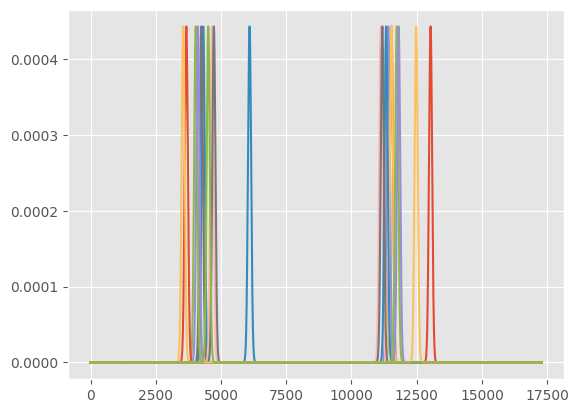

In [78]:
## Plot an example of what the labels look like
for i in range(10):
    plt.plot(y_train[i, :, 0])
    plt.plot(y_train[i, :, 1])

In [79]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

In [80]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Layer Definition

In [81]:
class ResidualBiLSTM(nn.Module):
    def __init__(self, hidden_size, n_layers=1, bidir=True):
        super(ResidualBiLSTM, self).__init__()
        # Initialize the Residual BiLSTM with specified hidden size, number of layers, and bidirectional option
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define the LSTM layer with the possibility of being bidirectional
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=bidir,)
        dir_factor = 2 if bidir else 1  # Factor to adjust dimensions based on bidirectionality

        # Fully connected layers for adding complexity
        self.fc1 = nn.Linear(hidden_size * dir_factor, hidden_size * dir_factor * 2)
        self.ln1 = nn.LayerNorm(hidden_size * dir_factor * 2)
        self.fc2 = nn.Linear(hidden_size * dir_factor * 2, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

    def forward(self, x, h=None):

        if h is None:
            h = (None, None)
        hidden_state, cell_state = h

        if hidden_state is None or cell_state is None:
            batch_size = x.size(0)
            num_directions = 2 if self.lstm.bidirectional else 1
            hidden_size = self.lstm.hidden_size
            hidden_state = torch.zeros(self.lstm.num_layers * num_directions, batch_size, hidden_size, device=x.device)
            cell_state = torch.zeros(self.lstm.num_layers * num_directions, batch_size, hidden_size, device=x.device)
        
        if len(x.size()) == 2:
            hidden_state = hidden_state.squeeze(1)
            cell_state = cell_state.squeeze(1)
            
        # LSTM layer processing and capturing new hidden and cell states   
        res, (new_h, new_c) = self.lstm(x, (hidden_state, cell_state))

        # Pass through fully connected layers
        res = self.fc1(res)
        res = self.ln1(res)
        res = nn.functional.relu(res)
        res = self.fc2(res)
        res = self.ln2(res)
        res = nn.functional.relu(res)

        # skip connection
        res = res + x

        return res, (new_h, new_c)

In [82]:
## Initial implementation of Soft Additive Attention where dimensions at shallow layer and upsampled layer were preserved
# However, it should be the downsampled decoder input that is an input into this layer

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm1d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


In [83]:
## More correct implementation of Soft Additive Attention
# Input from decoder is convolved to match the feature dimensions of the encoder layer residual
# Input from the encoder residual is downsampled to match the seqlen dimensions of the decoder input
# Psi goes through conv1d to reduce it down to 1 feature per sequence and is multiplied by the encoder input 


class AttentionGate2(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate2, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_l, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm1d(F_l)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_l, kernel_size=1, stride=2, padding=0, bias=True),
            nn.BatchNorm1d(F_l)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_l, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm1d(1),
            nn.Sigmoid(),
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):

        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi_init = self.relu(g1 + x1)
        psi = self.psi(psi_init)
        return x * psi


## Training

In [103]:
##Some common params

from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 1.e-3
clip_val = 2.
weight_decay=0.0

criterion = nn.KLDivLoss(reduction='sum', log_target=False)
m = nn.LogSoftmax(dim=1)  # Ensure correct dimension

arch = [(2, 8),
        (8, 32),
        (32, 64)]

## Train LSTMUNet

In [85]:
class LSTMUNET(nn.Module):
    def __init__(self, arch, seq_len, n_lstm_layers=2):
        super(LSTMUNET, self).__init__()
        
        
        self.n_lstm_layers=n_lstm_layers
        
        # Encoder (Downsampling Path)
        self.enc_conv0 = nn.Sequential(nn.Conv1d(arch[0][0], arch[0][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        self.enc_conv1 = nn.Sequential(nn.Conv1d(arch[1][0], arch[1][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        self.enc_conv2 = nn.Sequential(nn.Conv1d(arch[2][0], arch[2][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.ln1 = nn.LayerNorm([arch[0][1], seq_len])
        self.ln2 = nn.LayerNorm([arch[1][1], int(seq_len/2)])
        self.ln3 = nn.LayerNorm([arch[2][1], int(seq_len/4)])
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.res_bilstms = nn.ModuleList(
            [
                ResidualBiLSTM(hidden_size=64, n_layers=1, bidir=True)
                for _ in range(n_lstm_layers)
            ]
        )

        self.up_conv1 = nn.ConvTranspose1d(arch[2][1], arch[2][0], kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(nn.Conv1d(arch[2][0], arch[2][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.up_conv0 = nn.ConvTranspose1d(arch[1][1], arch[1][0], kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(nn.Conv1d(arch[1][0], arch[0][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        # Output Convolution
        self.out_conv = nn.Conv1d(arch[0][0], arch[0][0], kernel_size=1)

        self.dec_ln1 = nn.LayerNorm([32, int(seq_len/2)])  # Assuming 64 channels after concatenation in the first layer
        self.dec_ln0 = nn.LayerNorm([8, int(seq_len)])  # Assuming 16 channels after concatenation in the second layer
        
    def forward(self, x, states=None):
        # Encoder path
        
        if states is None:
            states = [(None, None) for _ in range(self.n_lstm_layers)]
        
        x = torch.permute(x, (0,2,1))
        x0 = self.enc_conv0(x)
        x0 = self.ln1(x0)
        p0 = self.pool(x0)

        x1 = self.enc_conv1(p0)
        x1 = self.ln2(x1)
        p1 = self.pool(x1)

        x2 = self.enc_conv2(p1)
        x2 = self.ln3(x2)

        x2 = torch.permute(x2, (0,2,1))
        new_states = []
        for i, res_bilstm in enumerate(self.res_bilstms):
            x2, new_state = res_bilstm(x2, states[i])
            new_states.append(new_state)
        x2 = torch.permute(x2, (0,2,1))
        
        # Decoder path
        u1 = self.up_conv1(x2)
        x1 = self.dec_ln1(u1)
        x1 = self.dec_conv1(x1)

        u0 = self.up_conv0(x1)
        x0 = self.dec_ln0(u0)
        x0 = self.dec_conv0(x0)
        
        # Output layer
        out = self.out_conv(x0)
        
        out = torch.permute(out, (0, 2, 1))
        return out, new_states

In [86]:
net = LSTMUNET(arch=arch, seq_len=24*60*12)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_epochs=20
T_max = num_epochs
eta_min = 1e-6
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

criterion = nn.KLDivLoss(reduction='sum', log_target=False)
m = nn.LogSoftmax(dim=1)  # Ensure correct dimension
net.to(device)
train_loss_history=[]
learning_rate_history = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    net.train()
    train_loss = 0

    for i, (x, y) in enumerate(train_loader):
        x_shape = x.shape
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        out, h = net(x)
        out = m(out)
        sums = y.sum(dim=1, keepdim=True)
        epsilon = 1e-8
        sums = sums + epsilon
        y = y / sums

        loss = criterion(out.float(), y.float())
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_val)
        optimizer.step()
        
        train_loss += loss.item()

        del loss
        
        clean_memory()
        
    scheduler.step()
    
    #normalize by length of sequence (which is 17280 for the length of one day)
    train_loss /= (x_shape[1])
    print(f'Epoch {epoch} train loss = {train_loss}')
    train_loss_history.append(train_loss)
    print(f'Learning Rate = {optimizer.param_groups[0]["lr"]}')
    learning_rate_history.append(optimizer.param_groups[0]["lr"])


Epochs:   5%|▌         | 1/20 [00:23<07:29, 23.67s/it]

Epoch 0 train loss = 1.0693681407857825
Learning Rate = 0.0009938503261272714


Epochs:  10%|█         | 2/20 [00:47<07:05, 23.64s/it]

Epoch 1 train loss = 0.740931651768861
Learning Rate = 0.0009755527298894295


Epochs:  15%|█▌        | 3/20 [01:10<06:41, 23.64s/it]

Epoch 2 train loss = 0.4194568720128801
Learning Rate = 0.0009455577588320899


Epochs:  20%|██        | 4/20 [01:34<06:18, 23.64s/it]

Epoch 3 train loss = 0.2788979759922734
Learning Rate = 0.0009046039886902865


Epochs:  25%|██▌       | 5/20 [01:58<05:54, 23.66s/it]

Epoch 4 train loss = 0.22721965622018886
Learning Rate = 0.0008536998372026806


Epochs:  30%|███       | 6/20 [02:21<05:31, 23.65s/it]

Epoch 5 train loss = 0.1916856958910271
Learning Rate = 0.0007940987335200905


Epochs:  35%|███▌      | 7/20 [02:45<05:07, 23.65s/it]

Epoch 6 train loss = 0.17836569106137312
Learning Rate = 0.0007272682546199038


Epochs:  40%|████      | 8/20 [03:09<04:43, 23.66s/it]

Epoch 7 train loss = 0.1637114425500234
Learning Rate = 0.0006548539886902865


Epochs:  45%|████▌     | 9/20 [03:32<04:20, 23.64s/it]

Epoch 8 train loss = 0.15012732104018883
Learning Rate = 0.0005786390152875956


Epochs:  50%|█████     | 10/20 [03:56<03:56, 23.65s/it]

Epoch 9 train loss = 0.1361232066595996
Learning Rate = 0.0005005000000000002


Epochs:  55%|█████▌    | 11/20 [04:20<03:32, 23.64s/it]

Epoch 10 train loss = 0.12207016150156656
Learning Rate = 0.000422360984712405


Epochs:  60%|██████    | 12/20 [04:43<03:09, 23.64s/it]

Epoch 11 train loss = 0.11541786282150834
Learning Rate = 0.00034614601130971394


Epochs:  65%|██████▌   | 13/20 [05:07<02:45, 23.65s/it]

Epoch 12 train loss = 0.10431953878314407
Learning Rate = 0.0002737317453800965


Epochs:  70%|███████   | 14/20 [05:31<02:21, 23.65s/it]

Epoch 13 train loss = 0.09183507694138421
Learning Rate = 0.00020690126647990978


Epochs:  75%|███████▌  | 15/20 [05:54<01:58, 23.64s/it]

Epoch 14 train loss = 0.08379267658348437
Learning Rate = 0.00014730016279731957


Epochs:  80%|████████  | 16/20 [06:18<01:34, 23.63s/it]

Epoch 15 train loss = 0.07644191527808154
Learning Rate = 9.639601130971382e-05


Epochs:  85%|████████▌ | 17/20 [06:41<01:10, 23.63s/it]

Epoch 16 train loss = 0.06903605334184788
Learning Rate = 5.54422411679103e-05


Epochs:  90%|█████████ | 18/20 [07:05<00:47, 23.63s/it]

Epoch 17 train loss = 0.06415995185573896
Learning Rate = 2.5447270110570818e-05


Epochs:  95%|█████████▌| 19/20 [07:29<00:23, 23.65s/it]

Epoch 18 train loss = 0.06079148498398286
Learning Rate = 7.149673872728741e-06


Epochs: 100%|██████████| 20/20 [07:52<00:00, 23.65s/it]

Epoch 19 train loss = 0.05911920360392994
Learning Rate = 1e-06


torch.Size([24, 17280, 2])
torch.Size([24, 17280, 2])


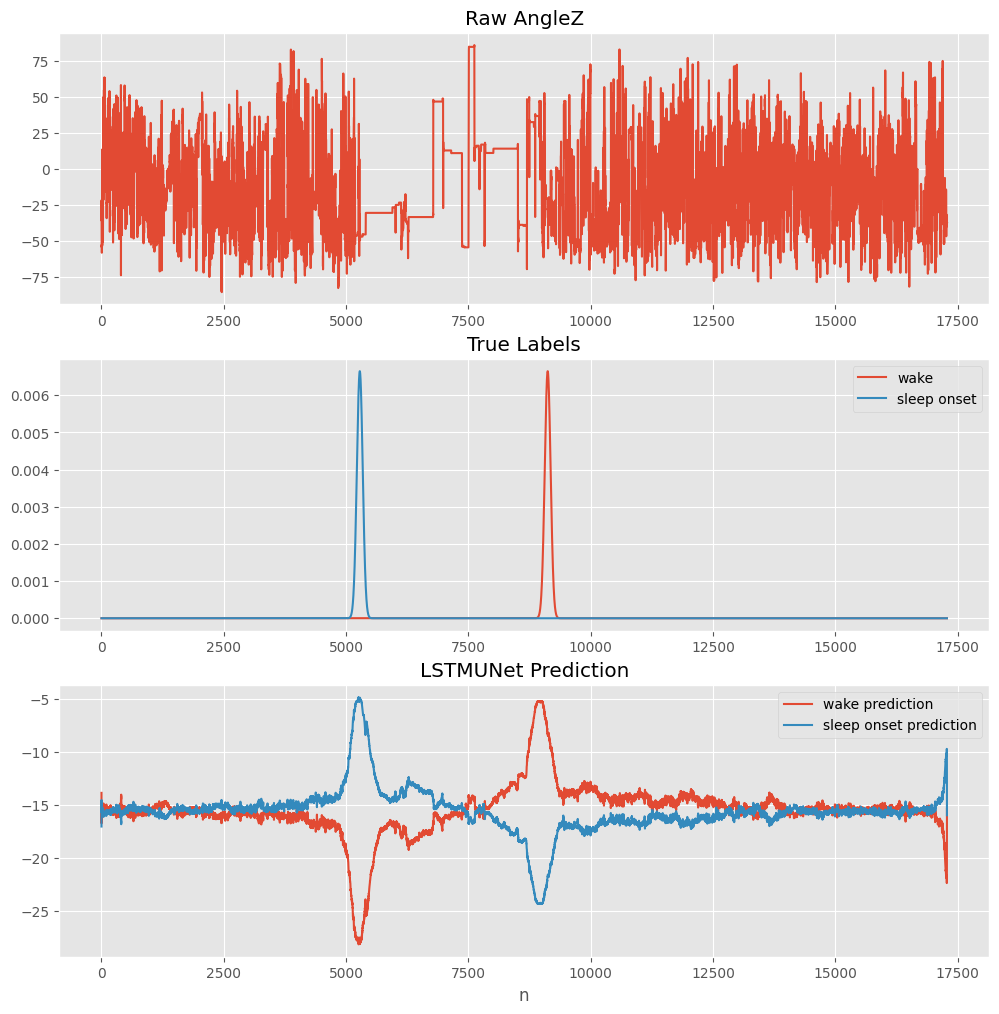

In [87]:
out_cpu = out.cpu()
y_cpu = y.cpu()
x_cpu = x.cpu()
print(out.shape)
print(y.shape)

sample_num=5

fig, ax = plt.subplots(3,1, figsize=(12,12))
# plt.figure(figsize=(12,8))
ax[0].plot(x_cpu[sample_num,:, 0].detach().numpy(), label='angle_z')
ax[0].set_title('Raw AngleZ')

ax[1].plot(y_cpu[sample_num, :,0].detach().numpy(), label='wake')
ax[1].plot(y_cpu[sample_num, :,1].detach().numpy(), label='sleep onset')
ax[1].set_title('True Labels')
ax[1].legend()


ax[2].plot(out_cpu[sample_num, :,0].detach().numpy(), label='wake prediction')
ax[2].plot(out_cpu[sample_num, :,1].detach().numpy(), label='sleep onset prediction')
ax[2].set_title('LSTMUNet Prediction')
plt.xlabel('n')
plt.legend()

Text(0.5, 1.0, 'LSTMUNet Loss History')

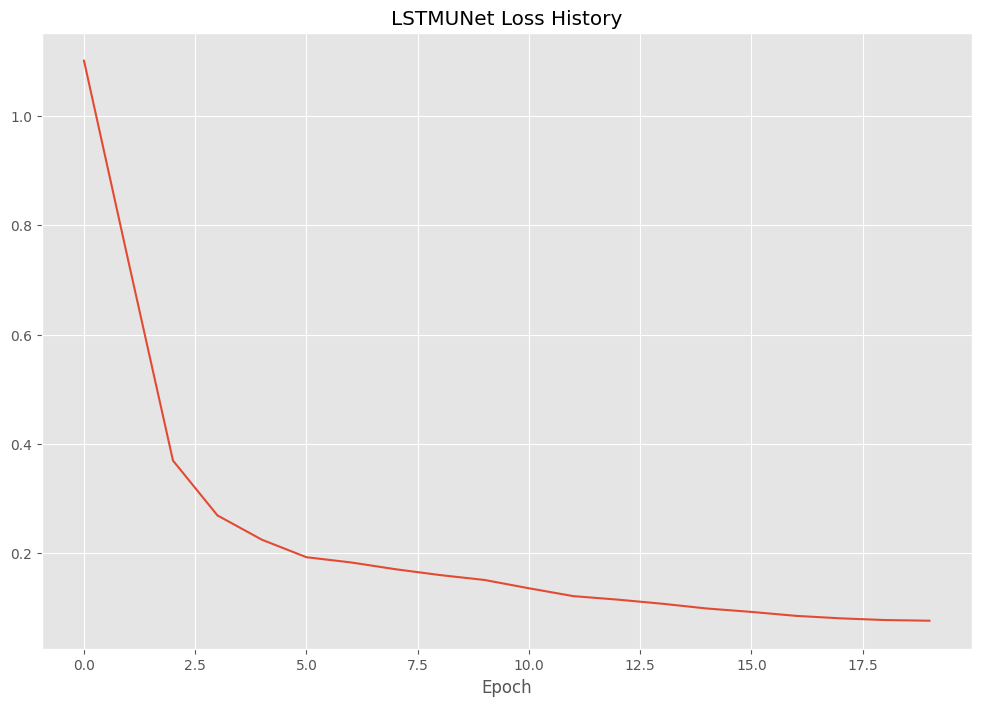

In [62]:
plt.figure(figsize=(12,8))
plt.plot(train_loss_history)
plt.xlabel('Epoch')
plt.title('LSTMUNet Loss History')

Text(0.5, 1.0, 'Learning Rate History')

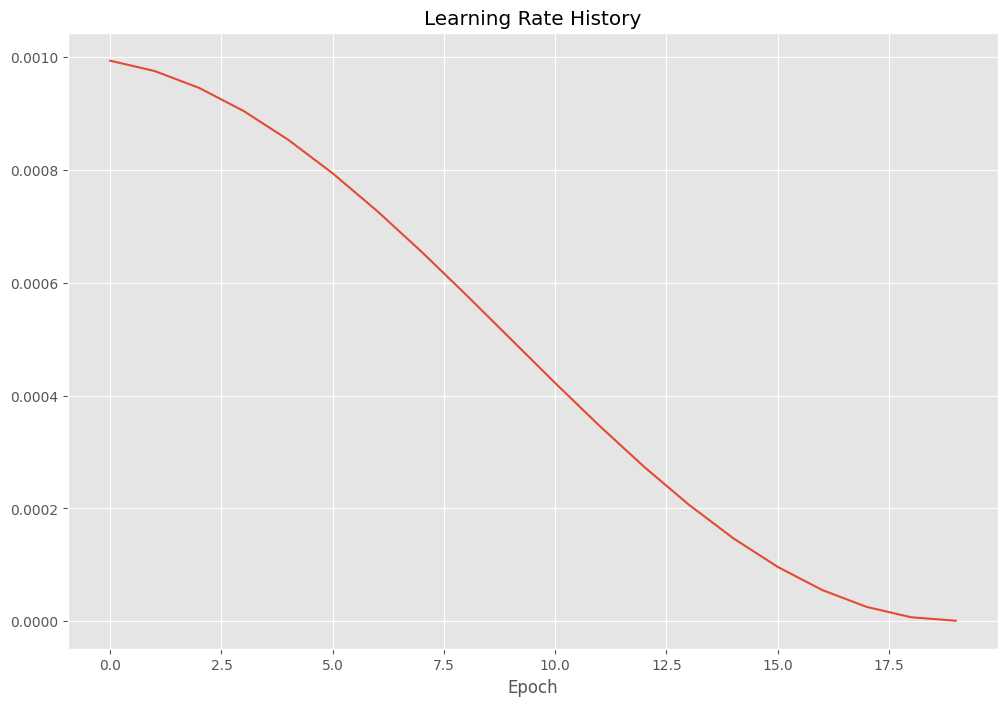

In [63]:
plt.figure(figsize=(12,8))
plt.plot(learning_rate_history)
plt.xlabel('Epoch')
plt.title('Learning Rate History')

## AttnUNet

In [88]:
class AttnUNET(nn.Module):
    def __init__(self, arch, seq_len):
        super(AttnUNET, self).__init__()
        
        
        
        # Encoder (Downsampling Path)
        self.enc_conv0 = nn.Sequential(nn.Conv1d(arch[0][0], arch[0][1], kernel_size=7, padding=3), nn.ReLU(inplace=True))
        self.enc_conv1 = nn.Sequential(nn.Conv1d(arch[1][0], arch[1][1], kernel_size=7, padding=3), nn.ReLU(inplace=True))
        self.enc_conv2 = nn.Sequential(nn.Conv1d(arch[2][0], arch[2][1], kernel_size=7, padding=3), nn.ReLU(inplace=True))
        
        self.ln1 = nn.LayerNorm([arch[0][1], seq_len])
        self.ln2 = nn.LayerNorm([arch[1][1], int(seq_len/2)])
        self.ln3 = nn.LayerNorm([arch[2][1], int(seq_len/4)])
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.up_conv1 = nn.ConvTranspose1d(arch[2][1], arch[2][0], kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(nn.Conv1d(arch[2][1], arch[2][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.up_conv0 = nn.ConvTranspose1d(arch[1][1], arch[1][0], kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(nn.Conv1d(2*arch[0][1], arch[0][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        # Output Convolution
        self.out_conv = nn.Conv1d(arch[0][0], arch[0][0], kernel_size=1)

        # Attention Gates
        self.att_gate1 = AttentionGate(F_g=arch[1][1], F_l=arch[1][1], F_int=arch[1][0])
        self.att_gate0 = AttentionGate(F_g=arch[0][1], F_l=arch[0][1], F_int=arch[0][0])
        
        self.dec_ln1 = nn.LayerNorm([64, int(seq_len/2)])  # Assuming 64 channels after concatenation in the first layer
        self.dec_ln0 = nn.LayerNorm([16, int(seq_len)])  # Assuming 16 channels after concatenation in the second layer
        
    def forward(self, x):
        # Encoder path
        
        x = torch.permute(x, (0,2,1))
        x0 = self.enc_conv0(x)
        x0 = self.ln1(x0)
        p0 = self.pool(x0)

        x1 = self.enc_conv1(p0)
        x1 = self.ln2(x1)
        p1 = self.pool(x1)

        x2 = self.enc_conv2(p1)
        x2 = self.ln3(x2)

        # Decoder path
        u1 = self.up_conv1(x2)
        g1 = self.att_gate1(g=x1, x=u1)
        x1 = torch.cat((g1, u1), dim=1)
        x1 = self.dec_ln1(x1)
        x1 = self.dec_conv1(x1)
        

        u0 = self.up_conv0(x1)
        g0 = self.att_gate0(g=x0, x=u0)
        x0 = torch.cat((g0, u0), dim=1)
        x0 = self.dec_ln0(x0)
        x0 = self.dec_conv0(x0)
        
        # Output layer
        out = self.out_conv(x0)
        
        out = torch.permute(out, (0, 2, 1))
        return out

In [89]:

net = AttnUNET(arch=arch,seq_len=24*60*12).to(CFG.DEVICE)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_epochs=20
T_max = num_epochs
eta_min = 1e-6
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

criterion = nn.KLDivLoss(reduction='sum', log_target=False)
m = nn.LogSoftmax(dim=1)  # Ensure correct dimension
net.to(device)
train_loss_history=[]
learning_rate_history = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    net.train()
    train_loss = 0

    for i, (x, y) in enumerate(train_loader):
        x_shape = x.shape
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        out = net(x)
        out = m(out)
        sums = y.sum(dim=1, keepdim=True)
        epsilon = 1e-8
        sums = sums + epsilon
        y = y / sums

        loss = criterion(out.float(), y.float())
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_val)
        optimizer.step()
        
        train_loss += loss.item()

        del loss
        
        clean_memory()
        
    scheduler.step()
    train_loss /= (x_shape[1])
    print(f'Epoch {epoch} train loss = {train_loss}')
    train_loss_history.append(train_loss)
    print(f'Learning Rate = {optimizer.param_groups[0]["lr"]}')
    learning_rate_history.append(optimizer.param_groups[0]["lr"])


Epochs:   5%|▌         | 1/20 [00:13<04:24, 13.91s/it]

Epoch 0 train loss = 1.0781264817273175
Learning Rate = 0.0009938503261272714


Epochs:  10%|█         | 2/20 [00:27<04:10, 13.91s/it]

Epoch 1 train loss = 0.9676009866926405
Learning Rate = 0.0009755527298894295


Epochs:  15%|█▌        | 3/20 [00:41<03:56, 13.91s/it]

Epoch 2 train loss = 0.8766264721199318
Learning Rate = 0.0009455577588320899


Epochs:  20%|██        | 4/20 [00:55<03:42, 13.90s/it]

Epoch 3 train loss = 0.810567605053937
Learning Rate = 0.0009046039886902865


Epochs:  25%|██▌       | 5/20 [01:09<03:28, 13.91s/it]

Epoch 4 train loss = 0.7816175752215915
Learning Rate = 0.0008536998372026806


Epochs:  30%|███       | 6/20 [01:23<03:14, 13.92s/it]

Epoch 5 train loss = 0.7577136525401362
Learning Rate = 0.0007940987335200905


Epochs:  35%|███▌      | 7/20 [01:37<03:00, 13.92s/it]

Epoch 6 train loss = 0.7430054832387853
Learning Rate = 0.0007272682546199038


Epochs:  40%|████      | 8/20 [01:51<02:47, 13.92s/it]

Epoch 7 train loss = 0.7295088176374083
Learning Rate = 0.0006548539886902865


Epochs:  45%|████▌     | 9/20 [02:05<02:33, 13.92s/it]

Epoch 8 train loss = 0.7171838574939304
Learning Rate = 0.0005786390152875956


Epochs:  50%|█████     | 10/20 [02:19<02:19, 13.92s/it]

Epoch 9 train loss = 0.704955115141692
Learning Rate = 0.0005005000000000002


Epochs:  55%|█████▌    | 11/20 [02:33<02:05, 13.92s/it]

Epoch 10 train loss = 0.6909580641322666
Learning Rate = 0.000422360984712405


Epochs:  60%|██████    | 12/20 [02:47<01:51, 13.92s/it]

Epoch 11 train loss = 0.6784983158111573
Learning Rate = 0.00034614601130971394


Epochs:  65%|██████▌   | 13/20 [03:00<01:37, 13.92s/it]

Epoch 12 train loss = 0.6663256247838338
Learning Rate = 0.0002737317453800965


Epochs:  70%|███████   | 14/20 [03:14<01:23, 13.92s/it]

Epoch 13 train loss = 0.6592362055072079
Learning Rate = 0.00020690126647990978


Epochs:  75%|███████▌  | 15/20 [03:28<01:09, 13.92s/it]

Epoch 14 train loss = 0.6507718510097927
Learning Rate = 0.00014730016279731957


Epochs:  80%|████████  | 16/20 [03:42<00:55, 13.92s/it]

Epoch 15 train loss = 0.6448977055373015
Learning Rate = 9.639601130971382e-05


Epochs:  85%|████████▌ | 17/20 [03:56<00:41, 13.93s/it]

Epoch 16 train loss = 0.6399494996777287
Learning Rate = 5.54422411679103e-05


Epochs:  90%|█████████ | 18/20 [04:10<00:27, 13.92s/it]

Epoch 17 train loss = 0.6346222330022742
Learning Rate = 2.5447270110570818e-05


Epochs:  95%|█████████▌| 19/20 [04:24<00:13, 13.92s/it]

Epoch 18 train loss = 0.6315313445197211
Learning Rate = 7.149673872728741e-06


Epochs: 100%|██████████| 20/20 [04:38<00:00, 13.92s/it]

Epoch 19 train loss = 0.6294884730268407
Learning Rate = 1e-06


torch.Size([24, 17280, 2])
torch.Size([24, 17280, 2])


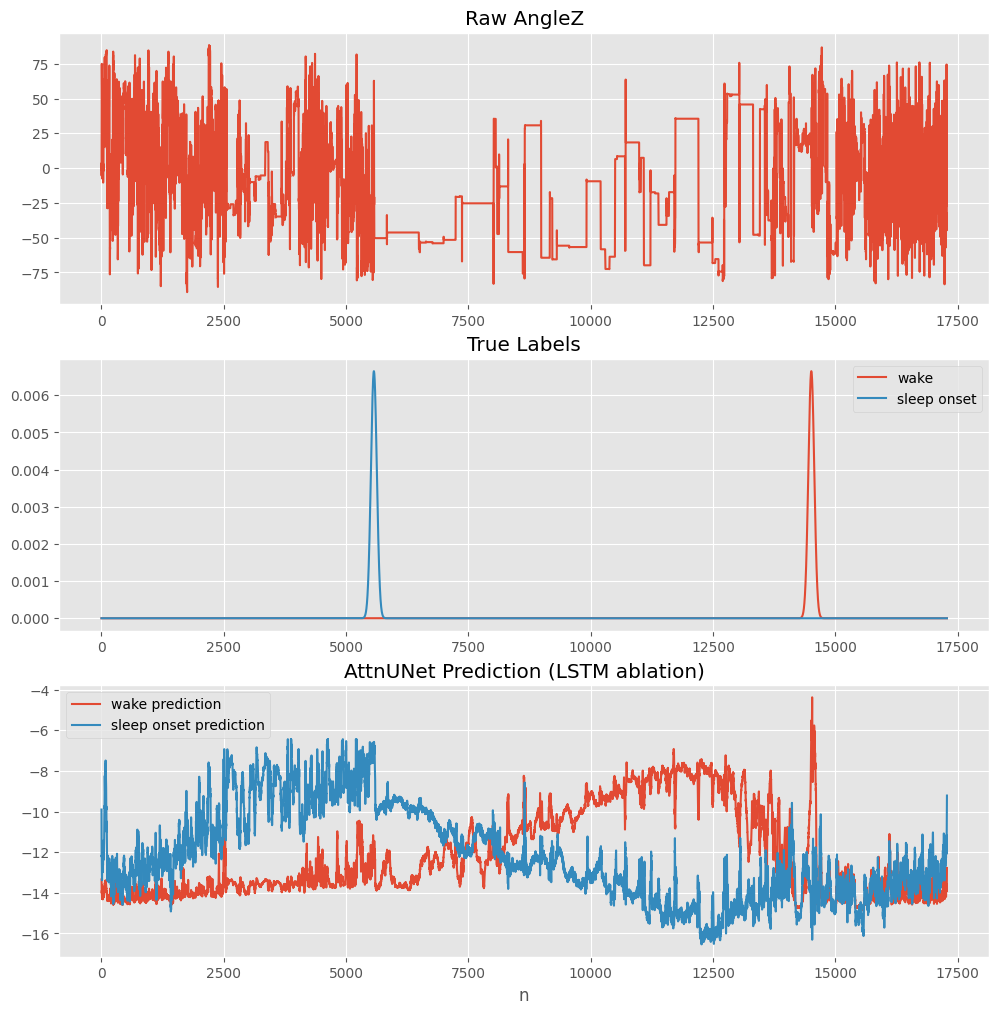

In [90]:
out_cpu = out.cpu()
y_cpu = y.cpu()
x_cpu = x.cpu()
print(out.shape)
print(y.shape)
#print(out[1,:100,1])

sample_num=5

fig, ax = plt.subplots(3,1, figsize=(12,12))
# plt.figure(figsize=(12,8))
ax[0].plot(x_cpu[sample_num,:, 0].detach().numpy(), label='angle_z')
ax[0].set_title('Raw AngleZ')

ax[1].plot(y_cpu[sample_num, :,0].detach().numpy(), label='wake')
ax[1].plot(y_cpu[sample_num, :,1].detach().numpy(), label='sleep onset')
ax[1].set_title('True Labels')
ax[1].legend()


ax[2].plot(out_cpu[sample_num, :,0].detach().numpy(), label='wake prediction')
ax[2].plot(out_cpu[sample_num, :,1].detach().numpy(), label='sleep onset prediction')
ax[2].set_title('AttnUNet Prediction (LSTM ablation)')
plt.xlabel('n')
plt.legend()

Text(0.5, 1.0, 'AttnUNet Loss History')

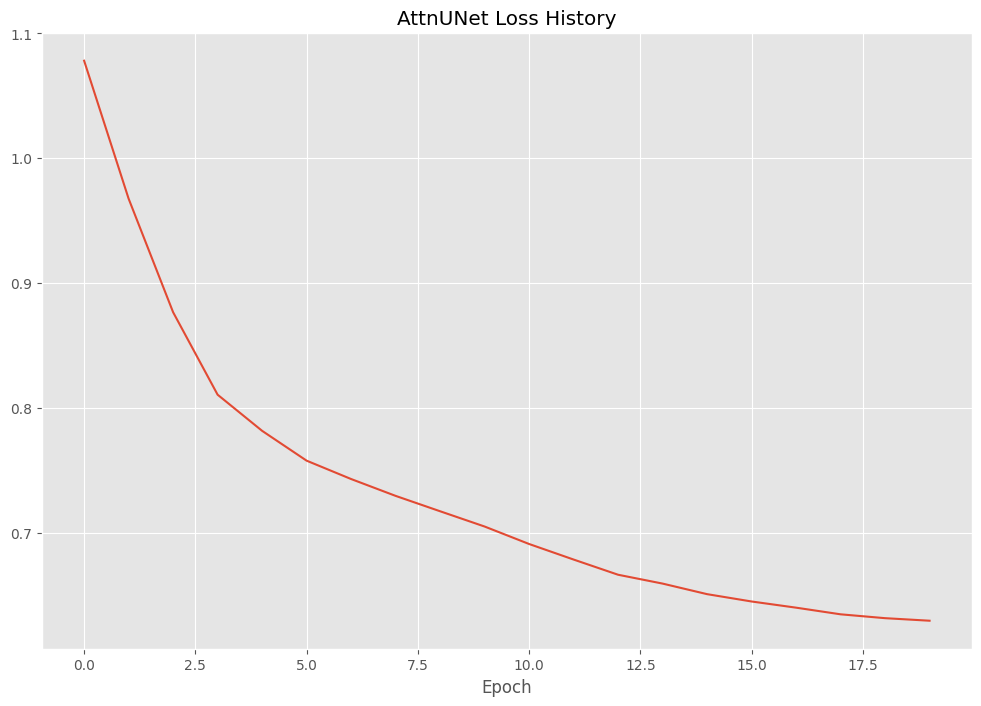

In [91]:
plt.figure(figsize=(12,8))
plt.plot(train_loss_history)
plt.xlabel('Epoch')
plt.title('AttnUNet Loss History')

## LSTMAttnUNet

In [95]:
class LSTMAttnUNET(nn.Module):
    def __init__(self, arch, seq_len, n_lstm_layers=2):
        super(LSTMAttnUNET, self).__init__()
        
        
        self.n_lstm_layers=n_lstm_layers
        
        # Encoder (Downsampling Path)
        self.enc_conv0 = nn.Sequential(nn.Conv1d(arch[0][0], arch[0][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        self.enc_conv1 = nn.Sequential(nn.Conv1d(arch[1][0], arch[1][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        self.enc_conv2 = nn.Sequential(nn.Conv1d(arch[2][0], arch[2][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.ln1 = nn.LayerNorm([arch[0][1], seq_len])
        self.ln2 = nn.LayerNorm([arch[1][1], int(seq_len/2)])
        self.ln3 = nn.LayerNorm([arch[2][1], int(seq_len/4)])
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.res_bilstms = nn.ModuleList(
            [
                ResidualBiLSTM(hidden_size=64, n_layers=1, bidir=True)
                for _ in range(n_lstm_layers)
            ]
        )

        self.up_conv1 = nn.ConvTranspose1d(arch[2][1], arch[2][0], kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(nn.Conv1d(arch[2][1], arch[2][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.up_conv0 = nn.ConvTranspose1d(arch[1][1], arch[1][0], kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(nn.Conv1d(2*arch[0][1], arch[0][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        # Output Convolution
        self.out_conv = nn.Conv1d(arch[0][0], arch[0][0], kernel_size=1)

        # Attention Gates
        self.att_gate1 = AttentionGate(F_g=arch[1][1], F_l=arch[1][1], F_int=arch[1][0])
        self.att_gate0 = AttentionGate(F_g=arch[0][1], F_l=arch[0][1], F_int=arch[0][0])
        
        self.dec_ln1 = nn.LayerNorm([64, int(seq_len/2)])  # Assuming 64 channels after concatenation in the first layer
        self.dec_ln0 = nn.LayerNorm([16, int(seq_len)])  # Assuming 16 channels after concatenation in the second layer
        
    def forward(self, x, states=None):
        # Encoder path
        
        if states is None:
            states = [(None, None) for _ in range(self.n_lstm_layers)]
        
        x = torch.permute(x, (0,2,1))
        x0 = self.enc_conv0(x)
        x0 = self.ln1(x0)
        p0 = self.pool(x0)

        x1 = self.enc_conv1(p0)
        x1 = self.ln2(x1)
        p1 = self.pool(x1)

        x2 = self.enc_conv2(p1)
        x2 = self.ln3(x2)

        x2 = torch.permute(x2, (0,2,1))
        new_states = []
        for i, res_bilstm in enumerate(self.res_bilstms):
            x2, new_state = res_bilstm(x2, states[i])
            new_states.append(new_state)
        x2 = torch.permute(x2, (0,2,1))
        
        # Decoder path
        u1 = self.up_conv1(x2)
        g1 = self.att_gate1(g=x1, x=u1)
        x1 = torch.cat((g1, u1), dim=1)
        x1 = self.dec_ln1(x1)
        x1 = self.dec_conv1(x1)

        u0 = self.up_conv0(x1)
        g0 = self.att_gate0(g=x0, x=u0)
        x0 = torch.cat((g0, u0), dim=1)
        x0 = self.dec_ln0(x0)
        x0 = self.dec_conv0(x0)
        
        # Output layer
        out = self.out_conv(x0)
        
        out = torch.permute(out, (0, 2, 1))
        return out, new_states

In [ ]:
net = LSTMAttnUNET(arch=arch,seq_len=24*60*12, n_lstm_layers=2).to(CFG.DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_epochs=20
T_max = num_epochs
eta_min = 1e-6
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

criterion = nn.KLDivLoss(reduction='sum', log_target=False)
m = nn.LogSoftmax(dim=1)  # Ensure correct dimension
net.to(device)
train_loss_history=[]
learning_rate_history = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    net.train()
    train_loss = 0

    for i, (x, y) in enumerate(train_loader):
        x_shape = x.shape
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        out, h = net(x)
        out = m(out)
        sums = y.sum(dim=1, keepdim=True)
        epsilon = 1e-8
        sums = sums + epsilon
        y = y / sums

        loss = criterion(out.float(), y.float())
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_val)
        optimizer.step()
        
        train_loss += loss.item()

        del loss
        
        clean_memory()
        
    scheduler.step()
    train_loss /= (x_shape[1])
    print(f'Epoch {epoch} train loss = {train_loss}')
    train_loss_history.append(train_loss)
    print(f'Learning Rate = {optimizer.param_groups[0]["lr"]}')
    learning_rate_history.append(optimizer.param_groups[0]["lr"])


Epochs:   5%|▌         | 1/20 [00:25<08:10, 25.83s/it]

Epoch 0 train loss = 1.066808322623924
Learning Rate = 0.0009938503261272714


Epochs:  10%|█         | 2/20 [00:51<07:44, 25.81s/it]

Epoch 1 train loss = 0.7977223263846503
Learning Rate = 0.0009755527298894295


Epochs:  15%|█▌        | 3/20 [01:17<07:18, 25.82s/it]

Epoch 2 train loss = 0.5071412289584124
Learning Rate = 0.0009455577588320899


Epochs:  20%|██        | 4/20 [01:43<06:53, 25.86s/it]

Epoch 3 train loss = 0.43277610430011043
Learning Rate = 0.0009046039886902865


Epochs:  25%|██▌       | 5/20 [02:09<06:27, 25.86s/it]

Epoch 4 train loss = 0.39677588255317126
Learning Rate = 0.0008536998372026806


Epochs:  30%|███       | 6/20 [02:34<06:01, 25.80s/it]

Epoch 5 train loss = 0.3673582229349348
Learning Rate = 0.0007940987335200905


torch.Size([24, 17280, 2])
torch.Size([24, 17280, 2])


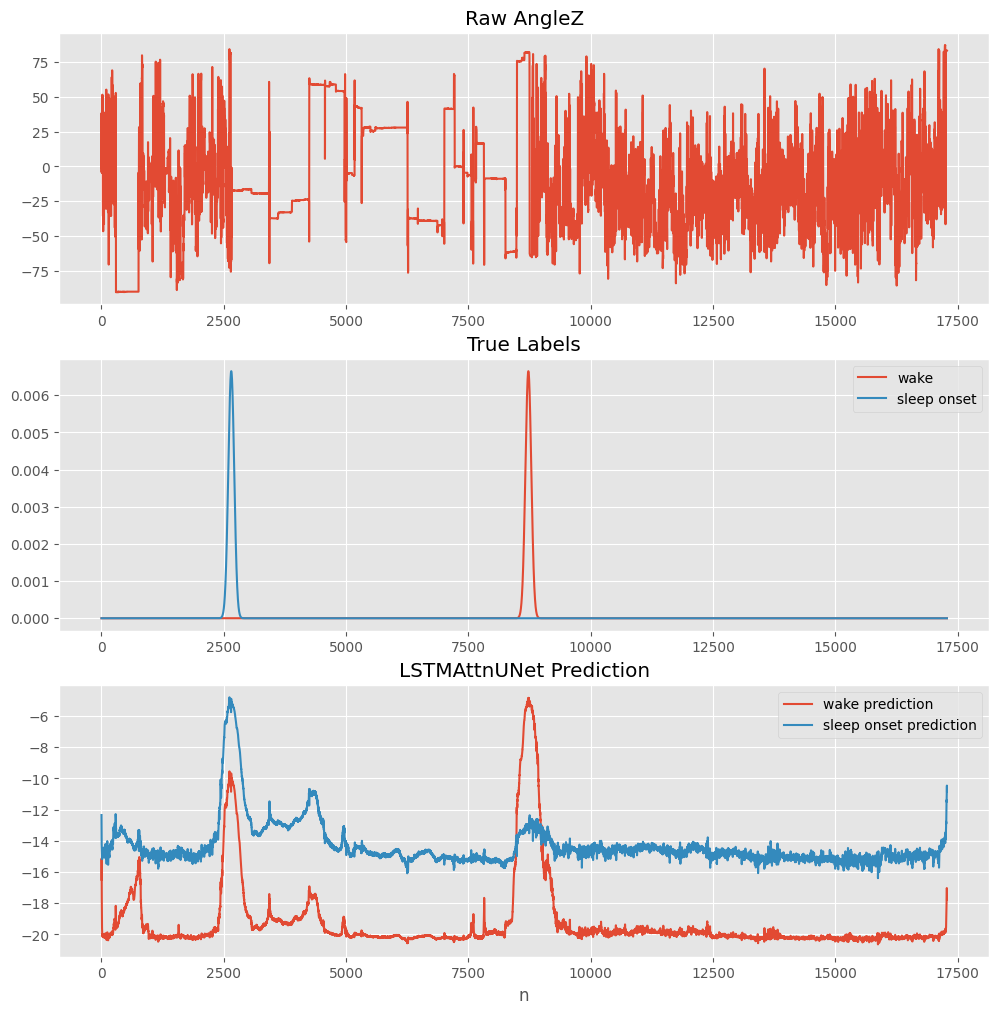

In [97]:
out_cpu = out.cpu()
y_cpu = y.cpu()
x_cpu = x.cpu()
print(out.shape)
print(y.shape)

sample_num=5

fig, ax = plt.subplots(3,1, figsize=(12,12))
# plt.figure(figsize=(12,8))
ax[0].plot(x_cpu[sample_num,:, 0].detach().numpy(), label='angle_z')
ax[0].set_title('Raw AngleZ')

ax[1].plot(y_cpu[sample_num, :,0].detach().numpy(), label='wake')
ax[1].plot(y_cpu[sample_num, :,1].detach().numpy(), label='sleep onset')
ax[1].set_title('True Labels')
ax[1].legend()


ax[2].plot(out_cpu[sample_num, :,0].detach().numpy(), label='wake prediction')
ax[2].plot(out_cpu[sample_num, :,1].detach().numpy(), label='sleep onset prediction')
ax[2].set_title('LSTMAttnUNet Prediction')
plt.xlabel('n')
plt.legend()

Text(0.5, 1.0, 'LSTMAttnUNet Loss History')

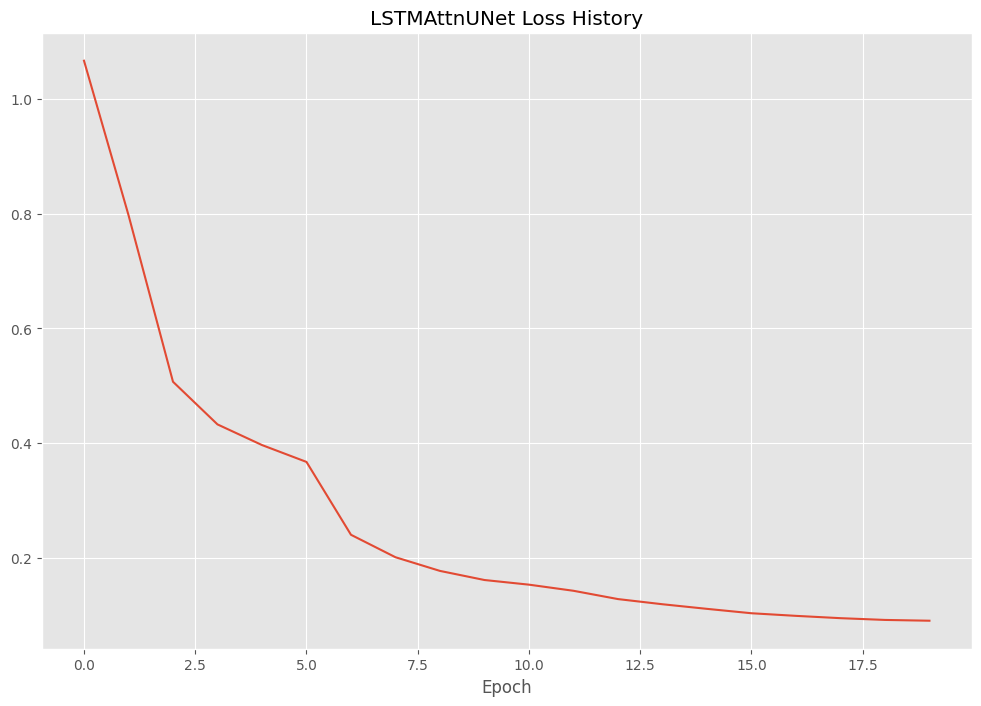

In [98]:
plt.figure(figsize=(12,8))
plt.plot(train_loss_history)
plt.xlabel('Epoch')
plt.title('LSTMAttnUNet Loss History')

## AttentionNet (with corrected attention gate)

In [99]:
class Attn2UNET(nn.Module):
    def __init__(self, arch, seq_len):
        super(Attn2UNET, self).__init__()
          
        # Encoder (Downsampling Path)
        self.enc_conv0 = nn.Sequential(nn.Conv1d(arch[0][0], arch[0][1], kernel_size=7, padding=3), nn.ReLU(inplace=True))
        self.enc_conv1 = nn.Sequential(nn.Conv1d(arch[1][0], arch[1][1], kernel_size=7, padding=3), nn.ReLU(inplace=True))
        self.enc_conv2 = nn.Sequential(nn.Conv1d(arch[2][0], arch[2][1], kernel_size=7, padding=3), nn.ReLU(inplace=True))
        
        self.ln1 = nn.LayerNorm([arch[0][1], seq_len])
        self.ln2 = nn.LayerNorm([arch[1][1], int(seq_len/2)])
        self.ln3 = nn.LayerNorm([arch[2][1], int(seq_len/4)])
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.up_conv1 = nn.ConvTranspose1d(arch[2][1], arch[2][0], kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(nn.Conv1d(arch[2][1], arch[2][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.up_conv0 = nn.ConvTranspose1d(arch[1][1], arch[1][0], kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(nn.Conv1d(2*arch[0][1], arch[0][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        # Output Convolution
        self.out_conv = nn.Conv1d(arch[0][0], arch[0][0], kernel_size=1)

        # Attention Gates
        self.att_gate1 = AttentionGate2(F_g=arch[2][1], F_l=arch[2][0], F_int=arch[2][0])
        self.att_gate0 = AttentionGate2(F_g=arch[1][1], F_l=arch[1][0], F_int=arch[1][0])
        
        self.dec_ln1 = nn.LayerNorm([64, int(seq_len/2)])  # Assuming 64 channels after concatenation in the first layer
        self.dec_ln0 = nn.LayerNorm([16, int(seq_len)])  # Assuming 16 channels after concatenation in the second layer
        
    def forward(self, x):
        # Encoder path
        
        x = torch.permute(x, (0,2,1))
        x0 = self.enc_conv0(x)
        x0 = self.ln1(x0)
        p0 = self.pool(x0)

        x1 = self.enc_conv1(p0)
        x1 = self.ln2(x1)
        p1 = self.pool(x1)

        x2 = self.enc_conv2(p1)
        x2 = self.ln3(x2)

        # Decoder path
        u1 = self.up_conv1(x2)
        g1 = self.att_gate1(g=x2, x=x1)
        x1 = torch.cat((g1, u1), dim=1)
        x1 = self.dec_ln1(x1)
        
        x1 = self.dec_conv1(x1)        

        u0 = self.up_conv0(x1)
        g0 = self.att_gate0(g=x1, x=x0)
        x0 = torch.cat((g0, u0), dim=1)
        x0 = self.dec_ln0(x0)
        x0 = self.dec_conv0(x0)

        # Output layer
        out = self.out_conv(x0)
        
        out = torch.permute(out, (0, 2, 1))
        return out

In [100]:

net = Attn2UNET(arch=arch,seq_len=24*60*12).to(CFG.DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_epochs=20
T_max = num_epochs
eta_min = 1e-6
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

criterion = nn.KLDivLoss(reduction='sum', log_target=False)
m = nn.LogSoftmax(dim=1)  # Ensure correct dimension
net.to(device)
train_loss_history=[]
learning_rate_history = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    net.train()
    train_loss = 0

    for i, (x, y) in enumerate(train_loader):
        x_shape = x.shape
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        out = net(x)
        out = m(out)
        sums = y.sum(dim=1, keepdim=True)
        epsilon = 1e-8
        sums = sums + epsilon
        y = y / sums

        loss = criterion(out.float(), y.float())
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_val)
        optimizer.step()
        
        train_loss += loss.item()

        del loss
        
        clean_memory()
        
    scheduler.step()
    train_loss /= (x_shape[1])
    print(f'Epoch {epoch} train loss = {train_loss}')
    train_loss_history.append(train_loss)
    print(f'Learning Rate = {optimizer.param_groups[0]["lr"]}')
    learning_rate_history.append(optimizer.param_groups[0]["lr"])

Epochs:   5%|▌         | 1/20 [00:15<04:53, 15.46s/it]

Epoch 0 train loss = 1.0719175285763212
Learning Rate = 0.0009938503261272714


Epochs:   5%|▌         | 1/20 [00:17<05:33, 17.54s/it]


KeyboardInterrupt: 

In [ ]:
out_cpu = out.cpu()
y_cpu = y.cpu()
x_cpu = x.cpu()
print(out.shape)
print(y.shape)

sample_num=5

fig, ax = plt.subplots(3,1, figsize=(12,12))
# plt.figure(figsize=(12,8))
ax[0].plot(x_cpu[sample_num,:, 0].detach().numpy(), label='angle_z')
ax[0].set_title('Raw AngleZ')

ax[1].plot(y_cpu[sample_num, :,0].detach().numpy(), label='wake')
ax[1].plot(y_cpu[sample_num, :,1].detach().numpy(), label='sleep onset')
ax[1].set_title('True Labels')
ax[1].legend()


ax[2].plot(out_cpu[sample_num, :,0].detach().numpy(), label='wake prediction')
ax[2].plot(out_cpu[sample_num, :,1].detach().numpy(), label='sleep onset prediction')
ax[2].set_title('AttnUNet Prediction')
plt.xlabel('n')
plt.legend()

## FINAL MODEL: LSTMATTNUNET2 (corrected attention gate)

In [101]:
class LSTMAttn2UNET(nn.Module):
    def __init__(self, arch, seq_len, n_lstm_layers=2):
        super(LSTMAttn2UNET, self).__init__()
        
        
        self.n_lstm_layers=n_lstm_layers
        
        # Encoder (Downsampling Path)
        self.enc_conv0 = nn.Sequential(nn.Conv1d(arch[0][0], arch[0][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        self.enc_conv1 = nn.Sequential(nn.Conv1d(arch[1][0], arch[1][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        self.enc_conv2 = nn.Sequential(nn.Conv1d(arch[2][0], arch[2][1], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.ln1 = nn.LayerNorm([arch[0][1], seq_len])
        self.ln2 = nn.LayerNorm([arch[1][1], int(seq_len/2)])
        self.ln3 = nn.LayerNorm([arch[2][1], int(seq_len/4)])
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.res_bilstms = nn.ModuleList(
            [
                ResidualBiLSTM(hidden_size=64, n_layers=1, bidir=True)
                for _ in range(n_lstm_layers)
            ]
        )

        self.up_conv1 = nn.ConvTranspose1d(arch[2][1], arch[2][0], kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(nn.Conv1d(arch[2][1], arch[2][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.up_conv0 = nn.ConvTranspose1d(arch[1][1], arch[1][0], kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(nn.Conv1d(2*arch[0][1], arch[0][0], kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        # Output Convolution
        self.out_conv = nn.Conv1d(arch[0][0], arch[0][0], kernel_size=1)

        # Attention Gates
        self.att_gate1 = AttentionGate2(F_g=arch[2][1], F_l=arch[2][0], F_int=arch[2][0])
        self.att_gate0 = AttentionGate2(F_g=arch[1][1], F_l=arch[1][0], F_int=arch[1][0])
        
        self.dec_ln1 = nn.LayerNorm([64, int(seq_len/2)])  # Assuming 64 channels after concatenation in the first layer
        self.dec_ln0 = nn.LayerNorm([16, int(seq_len)])  # Assuming 16 channels after concatenation in the second layer
        
    def forward(self, x, states=None):
        # Encoder path
        
        if states is None:
            states = [(None, None) for _ in range(self.n_lstm_layers)]
        
        x = torch.permute(x, (0,2,1))
        x0 = self.enc_conv0(x)
        x0 = self.ln1(x0)
        p0 = self.pool(x0)

        x1 = self.enc_conv1(p0)
        x1 = self.ln2(x1)
        p1 = self.pool(x1)

        x2 = self.enc_conv2(p1)
        x2 = self.ln3(x2)

        x2 = torch.permute(x2, (0,2,1))
        new_states = []
        for i, res_bilstm in enumerate(self.res_bilstms):
            x2, new_state = res_bilstm(x2, states[i])
            new_states.append(new_state)
        x2 = torch.permute(x2, (0,2,1))
        
        # Decoder path
        u1 = self.up_conv1(x2)
        g1 = self.att_gate1(g=x2, x=x1)
        x1 = torch.cat((g1, u1), dim=1)
        x1 = self.dec_ln1(x1)
        x1 = self.dec_conv1(x1)

        u0 = self.up_conv0(x1)
        g0 = self.att_gate0(g=x1, x=x0)
        x0 = torch.cat((g0, u0), dim=1)
        x0 = self.dec_ln0(x0)
        x0 = self.dec_conv0(x0)
        
        # Output layer
        out = self.out_conv(x0)
        
        out = torch.permute(out, (0, 2, 1))
        return out, new_states

In [102]:

net = LSTMAttn2UNET(arch=arch,seq_len=24*60*12).to(CFG.DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_epochs=20
T_max = num_epochs
eta_min = 1e-6
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

criterion = nn.KLDivLoss(reduction='sum', log_target=False)
m = nn.LogSoftmax(dim=1)  # Ensure correct dimension
net.to(device)
train_loss_history=[]
learning_rate_history = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    net.train()
    train_loss = 0

    for i, (x, y) in enumerate(train_loader):
        x_shape = x.shape
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        out, h = net(x)
        #print(out.shape)
        out = m(out)
        sums = y.sum(dim=1, keepdim=True)
        epsilon = 1e-8
        sums = sums + epsilon
        y = y / sums

        loss = criterion(out.float(), y.float())
        loss.backward()
        
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_val)
        optimizer.step()
        
        train_loss += loss.item()

        del loss
        
        clean_memory()
        
    scheduler.step()
    train_loss /= (x_shape[1])
    print(f'Epoch {epoch} train loss = {train_loss}')
    train_loss_history.append(train_loss)
    print(f'Learning Rate = {optimizer.param_groups[0]["lr"]}')
    learning_rate_history.append(optimizer.param_groups[0]["lr"])

Epochs:   5%|▌         | 1/20 [00:26<08:24, 26.53s/it]

Epoch 0 train loss = 1.097440356678433
Learning Rate = 0.0009938503261272714


Epochs:  10%|█         | 2/20 [00:53<07:56, 26.50s/it]

Epoch 1 train loss = 0.6985991884160925
Learning Rate = 0.0009755527298894295


Epochs:  15%|█▌        | 3/20 [01:19<07:32, 26.62s/it]

Epoch 2 train loss = 0.4598522676361932
Learning Rate = 0.0009455577588320899


Epochs:  20%|██        | 4/20 [01:47<07:09, 26.87s/it]

Epoch 3 train loss = 0.3475182208749983
Learning Rate = 0.0009046039886902865


Epochs:  25%|██▌       | 5/20 [02:14<06:45, 27.02s/it]

Epoch 4 train loss = 0.24721735804169268
Learning Rate = 0.0008536998372026806


Epochs:  30%|███       | 6/20 [02:40<06:14, 26.77s/it]

Epoch 5 train loss = 0.1844171964459949
Learning Rate = 0.0007940987335200905


Epochs:  35%|███▌      | 7/20 [03:06<05:45, 26.60s/it]

Epoch 6 train loss = 0.160262335340182
Learning Rate = 0.0007272682546199038


Epochs:  40%|████      | 8/20 [03:33<05:17, 26.49s/it]

Epoch 7 train loss = 0.15484085259614166
Learning Rate = 0.0006548539886902865


Epochs:  45%|████▌     | 9/20 [03:59<04:51, 26.52s/it]

Epoch 8 train loss = 0.130082096711353
Learning Rate = 0.0005786390152875956


Epochs:  50%|█████     | 10/20 [04:26<04:27, 26.71s/it]

Epoch 9 train loss = 0.11858725724396882
Learning Rate = 0.0005005000000000002


Epochs:  55%|█████▌    | 11/20 [04:53<04:01, 26.85s/it]

Epoch 10 train loss = 0.10637157382788481
Learning Rate = 0.000422360984712405


Epochs:  60%|██████    | 12/20 [05:20<03:33, 26.66s/it]

Epoch 11 train loss = 0.09519253985749351
Learning Rate = 0.00034614601130971394


Epochs:  65%|██████▌   | 13/20 [05:46<03:05, 26.54s/it]

Epoch 12 train loss = 0.08723049494955275
Learning Rate = 0.0002737317453800965


Epochs:  70%|███████   | 14/20 [06:12<02:38, 26.45s/it]

Epoch 13 train loss = 0.07618495910255997
Learning Rate = 0.00020690126647990978


Epochs:  75%|███████▌  | 15/20 [06:39<02:12, 26.53s/it]

Epoch 14 train loss = 0.06840740480908641
Learning Rate = 0.00014730016279731957


Epochs:  80%|████████  | 16/20 [07:06<01:46, 26.71s/it]

Epoch 15 train loss = 0.06230504559697928
Learning Rate = 9.639601130971382e-05


Epochs:  85%|████████▌ | 17/20 [07:33<01:20, 26.84s/it]

Epoch 16 train loss = 0.05558228754886874
Learning Rate = 5.54422411679103e-05


Epochs:  90%|█████████ | 18/20 [07:59<00:53, 26.67s/it]

Epoch 17 train loss = 0.05117233141704842
Learning Rate = 2.5447270110570818e-05


Epochs:  95%|█████████▌| 19/20 [08:26<00:26, 26.55s/it]

Epoch 18 train loss = 0.04851235686628907
Learning Rate = 7.149673872728741e-06


Epochs: 100%|██████████| 20/20 [08:52<00:00, 26.63s/it]

Epoch 19 train loss = 0.04692334209879239
Learning Rate = 1e-06


torch.Size([24, 17280, 2])
torch.Size([24, 17280, 2])


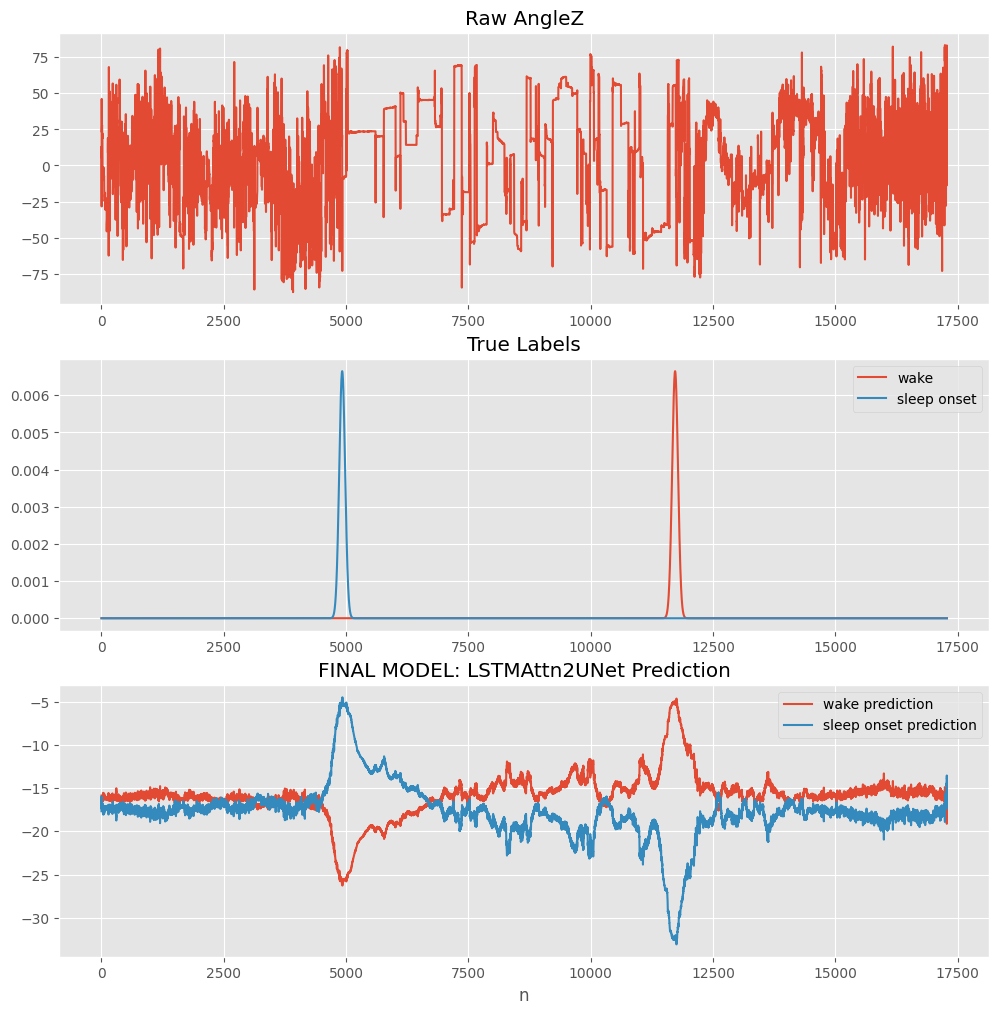

In [105]:
out_cpu = out.cpu()
y_cpu = y.cpu()
x_cpu = x.cpu()
print(out.shape)
print(y.shape)

sample_num=5

fig, ax = plt.subplots(3,1, figsize=(12,12))
# plt.figure(figsize=(12,8))
ax[0].plot(x_cpu[sample_num,:, 0].detach().numpy(), label='angle_z')
ax[0].set_title('Raw AngleZ')

ax[1].plot(y_cpu[sample_num, :,0].detach().numpy(), label='wake')
ax[1].plot(y_cpu[sample_num, :,1].detach().numpy(), label='sleep onset')
ax[1].set_title('True Labels')
ax[1].legend()


ax[2].plot(out_cpu[sample_num, :,0].detach().numpy(), label='wake prediction')
ax[2].plot(out_cpu[sample_num, :,1].detach().numpy(), label='sleep onset prediction')
ax[2].set_title('FINAL MODEL: LSTMAttn2UNet Prediction')
plt.xlabel('n')
plt.legend()

## Evaluation

In [106]:
print(net)

LSTMAttn2UNET(
  (enc_conv0): Sequential(
    (0): Conv1d(2, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
  )
  (enc_conv1): Sequential(
    (0): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
  )
  (ln1): LayerNorm((8, 17280), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((32, 8640), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((64, 4320), eps=1e-05, elementwise_affine=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res_bilstms): ModuleList(
    (0): ResidualBiLSTM(
      (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
      (fc1): Linear(in_features=128, out_features=256, bias=True)
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (fc2): Linear(in_features=256, out_features=64, bias=True)
 

In [107]:
# Validation

print('Evaluate test Loss and mAP')

net.eval()

all_predictions = torch.Tensor().to(device)
all_targets = torch.Tensor().to(device)

def find_max_idx(pred,y, dim=1):
    pred_max_idx = torch.argmax(pred, dim)
    y_max_idx = torch.argmax(y, dim)
    return pred_max_idx, y_max_idx

with torch.no_grad():
    for i, (x,y) in tqdm(enumerate(test_loader)):
        print('batch: ', i)

        x, y = x.to(device), y.to(device)
        out, h = net(x)
        out = m(out)

        all_predictions = torch.cat((all_predictions, out), dim=0)
        all_targets = torch.cat((all_targets, y), dim=0)

Evaluate test Loss and mAP


4it [00:00, 33.26it/s]

batch:  0
batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6


12it [00:00, 30.26it/s]

batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13


20it [00:00, 30.24it/s]

batch:  14
batch:  15
batch:  16
batch:  17
batch:  18
batch:  19
batch:  20


24it [00:00, 30.21it/s]

batch:  21
batch:  22
batch:  23
batch:  24
batch:  25
batch:  26
batch:  27


32it [00:01, 30.13it/s]

batch:  28
batch:  29
batch:  30
batch:  31
batch:  32
batch:  33
batch:  34


40it [00:01, 30.07it/s]

batch:  35
batch:  36
batch:  37
batch:  38
batch:  39
batch:  40
batch:  41


48it [00:01, 30.00it/s]

batch:  42
batch:  43
batch:  44
batch:  45
batch:  46
batch:  47


52it [00:01, 29.93it/s]

batch:  48
batch:  49
batch:  50
batch:  51
batch:  52
batch:  53


58it [00:01, 29.88it/s]

batch:  54
batch:  55
batch:  56
batch:  57
batch:  58
batch:  59
batch:  60


64it [00:02, 29.82it/s]

batch:  61
batch:  62
batch:  63
batch:  64
batch:  65
batch:  66


70it [00:02, 29.76it/s]

batch:  67
batch:  68
batch:  69
batch:  70
batch:  71
batch:  72


76it [00:02, 29.69it/s]

batch:  73
batch:  74
batch:  75
batch:  76
batch:  77
batch:  78


79it [00:02, 29.28it/s]


In [108]:
print(all_predictions.shape)
print(all_targets.shape)

torch.Size([627, 17280, 2])
torch.Size([627, 17280, 2])


In [109]:
pred_max_idx, y_max_idx = find_max_idx(all_predictions, all_targets)
final_pred = torch.zeros(all_predictions.shape)
final_y = torch.zeros(all_targets.shape)
for i in range(len(final_pred)):
    on = pred_max_idx[i]
    off = y_max_idx[i]
    final_pred[i, on[0], 0] = 1
    final_pred[i, on[1], 1] = 1
    
    final_y[i, off[0], 0] = 1
    final_y[i, off[1], 1] = 1
    
    
print(final_pred.shape)
print(final_y.shape)
print(torch.argmax(final_pred[10], dim=0))
print(torch.argmax(final_y[10], dim=0))

torch.Size([627, 17280, 2])
torch.Size([627, 17280, 2])
tensor([10507,  6036])
tensor([10451,  6023])


In [110]:
# print(torch.argmax(final_pred[:10], dim=1))
# print(torch.argmax(final_y[:10], dim=1))

In [114]:
# match predictions to nearest target and then calculate ap
    
from sklearn.metrics import average_precision_score, recall_score

tolerances = [12, 30, 60, 90, 120, 150, 180, 240, 300, 360]
auprc_history = []
ap_history=[]
recall_history=[]
for tolerance in tolerances:
    new_final_pred = final_pred.clone()
    for i, (sample, target) in enumerate(zip(final_pred, final_y)):
        pred_idx = torch.argmax(sample, dim=0)
        y_idx = torch.argmax(target, dim=0)

        dist = torch.sub(pred_idx, y_idx)
        outside = abs(dist)<tolerance
        new_pred_idx = pred_idx.masked_fill(outside, 0)
        #print(new_pred_idx)
        for j in range(len(new_pred_idx)):
            if new_pred_idx[j] == 0:
                new_final_pred[i, pred_idx[j],j] = 0
                new_final_pred[i, y_idx[j], j] = 1
            else:
                continue
    
    
    # Flatten the tensors for sklearn compatibility
    flat_pred = new_final_pred.view(-1).cpu().numpy()
    flat_y = final_y.view(-1).cpu().numpy()

    # Calculate the Average Precision
    ap = average_precision_score(flat_y, flat_pred)
    ap_history.append(ap)
    
    recall = recall_score(flat_y, flat_pred)
    recall_history.append(recall)
    
#     auprc = binary_auprc(new_final_pred, final_y)
#     auprc_history.append(auprc)
    

mAP = sum(ap_history)/len(tolerances)
print(mAP)

0.6083850511872553


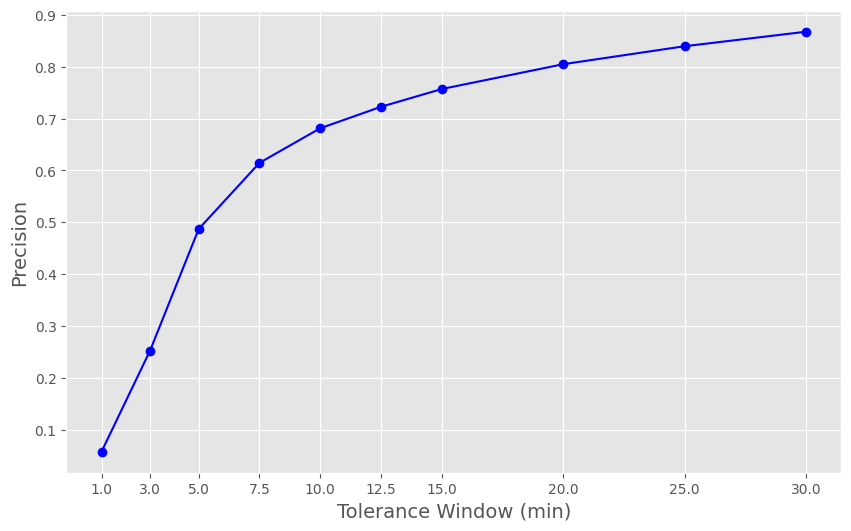

In [115]:
#plt.plot(ap_history)
#plt.title('Average Precision - LSTMUNet')
#Generating example data for Mean Average Precision over different tolerance values
tolerances = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]  # Example tolerance values
map_values = ap_history  #Randomly generated mAP values for illustration

#Re-creating the plot with specified adjustments
plt.figure(figsize=(10, 6))
plt.plot(tolerances, ap_history, marker='o', color='blue', label=f'mAP = {np.mean(map_values):.2f}')
#plt.title("Mean Average Precision (mAP) over Tolerance", fontsize=14)
plt.xlabel("Tolerance Window (min)", fontsize=14)
plt.ylabel("Precision", fontsize=14)

#Adjusting the x-axis tick labels to show tolerance/12
x_ticks_labels = [f"{int(tol)/12}" for tol in tolerances]
plt.xticks(tolerances, x_ticks_labels, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
#plt.legend(fontsize=12)
plt.show()


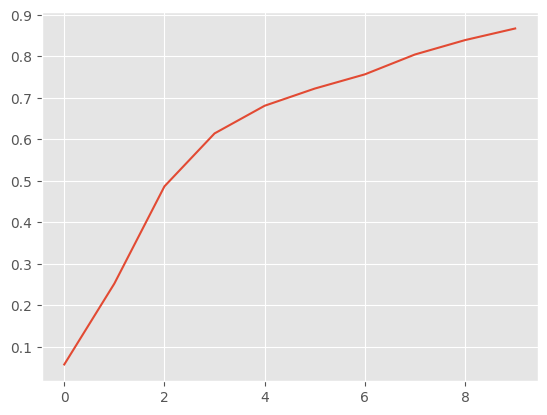

In [116]:
plt.plot(ap_history)